In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import rcParams
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import pickle
import xarray as xr
from os.path import join
from glob import glob
from matplotlib.animation import FuncAnimation
from lorenz_gan.submodels import SubModelGAN, AR1RandomUpdater
from lorenz_gan.analysis import hellinger, calc_pdf_hist

Using TensorFlow backend.


In [8]:
data_path = "/glade/work/dgagne/exp_20_stoch/offline_25/"

In [ ]:
/glade/work/dgagne/exp_20_stoch/off

In [3]:
ls /glade/work/dgagne/exp_20_stoch/offline

gan_100_det_offline_predictions.csv   gan_500_det_offline_predictions.csv
gan_100_noise_corr.csv                gan_500_noise_corr.csv
gan_100_offline_hellinger.csv         gan_500_offline_hellinger.csv
gan_100_offline_pdfs.csv              gan_500_offline_pdfs.csv
gan_100_rand_offline_predictions.csv  gan_500_rand_offline_predictions.csv
gan_100_time_correlations.csv         gan_500_time_correlations.csv
gan_101_det_offline_predictions.csv   gan_501_det_offline_predictions.csv
gan_101_noise_corr.csv                gan_501_noise_corr.csv
gan_101_offline_hellinger.csv         gan_501_offline_hellinger.csv
gan_101_offline_pdfs.csv              gan_501_offline_pdfs.csv
gan_101_rand_offline_predictions.csv  gan_501_rand_offline_predictions.csv
gan_101_time_correlations.csv         gan_501_time_correlations.csv
gan_102_det_offline_predictions.csv   gan_502_det_offline_predictions.csv
gan_102_noise_corr.csv                gan_502_noise_corr.csv
gan_102_offline_hellinger.csv         gan_502_o

In [9]:
gan_index_label = {100: "XU-lrg-w",
                   101: "XU-med-w",
                   102: "XU-sml-w",
                   103: "XU-tny-w",
                   202: "X-sml-w",
                   203: "X-tny-w",
                   500: "XU-lrg-r",
                   501: "XU-med-r",
                   502: "XU-sml-r",
                   503: "XU-tny-r",
                   602: "X-sml-r",
                   603: "X-tny-r",
                   702: "XU-sml-r-n"}
gan_index_color = {100: (0, 0.3052, 0.5057),
                   101: (0, 0.4470, 0.7410),
                   102: (0, 0.5364, 0.8892),
                   103: (0, 0.7558, 1),
                   202: (0.2796, 0.4044, 0.1128),
                   203: (0.5126, 0.7414, 0.2068),
                   500: (0.4250, 0.1625, 0.0490),
                   501: (0.6375, 0.2438, 0.0735),
                   502: (0.8500, 0.3250, 0.0980),
                   503: (1.0, 0.3930, 0.1186),
                   602: (0.7432, 0.5552, 0.100),
                   603: (1, 0.83280, 0.150),
                   702: (0, 0.5364, 0.8892)}

## Hellinger Distance

We first plot the Hellinger distances with epoch for each GAN. We plot the hellinger distances of the pdfs for the deterministic predictions,
then the white noise and red noise offline predictions.

In [10]:
hellinger_files = sorted(glob(join(data_path, "gan_*_offline_hellinger.csv")))
hellinger_data = {}
for hellinger_file in hellinger_files:
    gan_index = int(hellinger_file.split("/")[-1].split("_")[1])
    hellinger_data[gan_index] = pd.read_csv(hellinger_file, index_col="Epoch")

In [11]:
test_data = pd.read_csv("/glade/work/dgagne/exp_20_stoch/lorenz_combined_output_test_x0.csv")
with open("/glade/work/dgagne/exp_20_stoch/u_poly_add.pkl", 'rb') as poly_file:
    poly_model = pickle.load(poly_file)
poly_pred = poly_model.predict_mean(test_data[["X_t"]].values)
poly_res = test_data["Ux_t+1"].values - poly_pred
poly_corr = np.corrcoef(poly_res[1:], poly_res[:-1])[0, 1]
pdf_bins = np.arange(-16, 23, 0.1)
truth_pdf = calc_pdf_hist(test_data["Ux_t+1"].values, pdf_bins)
poly_det_pdf = calc_pdf_hist(poly_pred, pdf_bins)
poly_hellinger_det = hellinger(pdf_bins[:-1], poly_det_pdf, truth_pdf)

/glade/work/dgagne/ncar_pylib_dl/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LinearRegression from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [12]:
poly_rand_res = np.random.normal(loc=0, scale=poly_model.res_sd, size=poly_pred.size)
poly_rand_pred = poly_pred + poly_rand_res
poly_rand_pdf = calc_pdf_hist(poly_rand_pred, pdf_bins)
poly_hellinger_rand = hellinger(pdf_bins[:-1], poly_rand_pdf, truth_pdf)

In [36]:
poly_hellinger_rand

0.005645366381174259

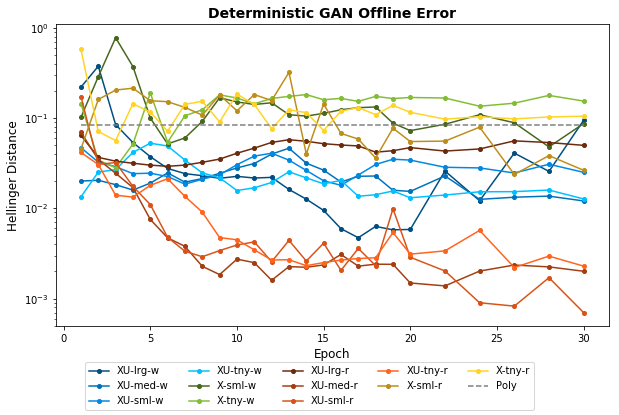

In [13]:
fig = plt.figure(figsize=(8, 6))
plt.subplots_adjust(0.02, 0.2, 0.98, 0.9)
gan_indices = sorted(list(hellinger_data.keys()))
lines = []
labels = []
for gan_index in gan_indices:
    lines.append(plt.plot(hellinger_data[gan_index].index, 
             hellinger_data[gan_index]["{0:04d}_det".format(gan_index)],
             color=gan_index_color[gan_index],
             marker='o',
             ms=4,
             label=gan_index_label[gan_index])[0])
    labels.append(gan_index_label[gan_index])

lines.append(plt.plot(hellinger_data[502].index, 
         poly_hellinger_det * np.ones(hellinger_data[502].shape[0]),
             color="gray",
             marker=None,
             linestyle="--",
             ms=4,
             label="Poly")[0])
labels.append("Poly")
fig.legend(lines, labels, ncol=5, fontsize=10, loc='lower center')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Hellinger Distance", fontsize=12)
plt.gca().set_yscale("log")
plt.title("Deterministic GAN Offline Error", fontsize=14, fontweight="bold")
plt.savefig("/glade/work/dgagne/exp_20_stoch/offline/hellinger_epoch_det.pdf", bbox_inches="tight")

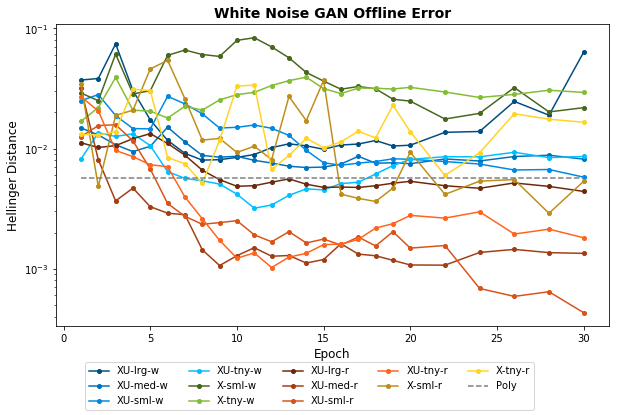

In [18]:
fig = plt.figure(figsize=(8,6))
plt.subplots_adjust(0.02, 0.2, 0.98, 0.9)
gan_indices = sorted(list(hellinger_data.keys()))
lines = []
labels = []
for gan_index in gan_indices:
    lines.append(plt.plot(hellinger_data[gan_index].index, 
             hellinger_data[gan_index]["{0:04d}_rand".format(gan_index)],
             color=gan_index_color[gan_index],
             marker='o',
             ms=4,
             label=gan_index_label[gan_index])[0])
    labels.append(gan_index_label[gan_index])
lines.append(plt.plot(hellinger_data[502].index, 
         poly_hellinger_rand * np.ones(hellinger_data[502].shape[0]),
             color="gray",
             marker=None,
             linestyle="--",
             ms=4,
             label="Poly")[0])
labels.append("Poly")
fig.legend(lines, labels, ncol=5, fontsize=10, loc='lower center')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Hellinger Distance", fontsize=12)
plt.gca().set_yscale("log")
plt.title("White Noise GAN Offline Error", fontsize=14, fontweight="bold")
plt.savefig("/glade/work/dgagne/exp_20_stoch/offline/hellinger_epoch_rand.pdf", bbox_inches="tight")

## Noise Correlations

We calculate the lag-1 autocorrelation for the residuals of each deterministic GAN at different epochs.

In [15]:
noise_corr_files = sorted(glob(join(data_path, "gan_*_noise_corr.csv")))
noise_corr_data = {}
for noise_corr_file in noise_corr_files:
    gan_index = int(noise_corr_file.split("/")[-1].split("_")[1])
    noise_corr_data[gan_index] = pd.read_csv(noise_corr_file, index_col="Model")
    noise_corr_data[gan_index].loc[:, "Epoch"] = pd.Series(noise_corr_data[gan_index].index).str.split("_").str[-1].str[:-3].values.astype(int)

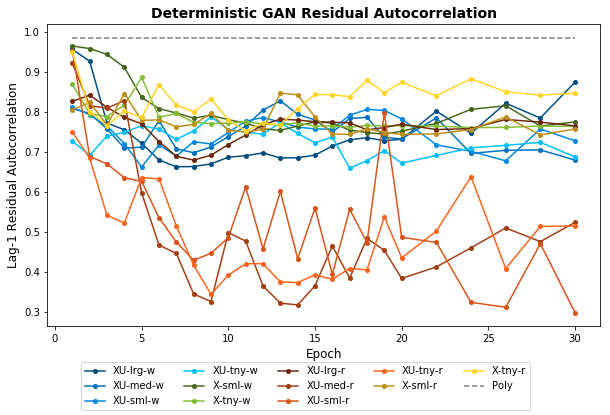

In [17]:
fig = plt.figure(figsize=(8 ,6))
plt.subplots_adjust(0.02, 0.2, 0.98, 0.9)
gan_indices = sorted(list(noise_corr_data.keys()))
lines = []
labels = []
for gan_index in gan_indices:
    lines.append(plt.plot(noise_corr_data[gan_index]["Epoch"], 
             noise_corr_data[gan_index]["corr"],
             color=gan_index_color[gan_index],
             marker='o',
             ms=4,
             label=gan_index_label[gan_index])[0])
    labels.append(gan_index_label[gan_index])
lines.append(plt.plot(noise_corr_data[502]["Epoch"], poly_corr * np.ones(noise_corr_data[502]["Epoch"].size), 
                      color='gray', linestyle='--', label="Poly")[0])
labels.append("Poly")
#plt.yticks(np.arange(0.9, 1.01, 0.01))
fig.legend(lines, labels, ncol=5, fontsize=10, loc='lower center')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Lag-1 Residual Autocorrelation", fontsize=12)
#plt.gca().set_yscale("log")
plt.title("Deterministic GAN Residual Autocorrelation", fontsize=14, fontweight="bold")
plt.savefig("/glade/work/dgagne/exp_20_stoch/offline/res_autocorr_epoch_det.pdf", bbox_inches="tight")

In [16]:
ar1_out_path = "/glade/work/dgagne/exp_20_stoch/offline/ar1/"
for gan_index in sorted(list(noise_corr_data.keys())):
    ar1 = AR1RandomUpdater(*noise_corr_data[gan_index].iloc[-1][["corr", "noise_sd"]].tolist())
    print(gan_index, ar1.corr, ar1.noise_sd)
    with open(join(ar1_out_path, f"ar1_random_updater_{gan_index:04d}.pkl"), "wb") as ar1_file:
        pickle.dump(ar1, ar1_file)

500 0.9844629999999999 0.17559233
501 0.9378030999999999 0.3471676
502 0.9039780000000001 0.427579
503 0.9361624 0.35156775
602 0.9851879000000001 0.17147826
603 0.9908078000000001 0.13527735
702 0.9218495999999999 0.38754785


Plot pdfs

In [78]:
pdfs = pd.read_csv(join(data_path, "gan_501_offline_pdfs.csv"), index_col="Bins")

In [83]:
hellinger_data[100].index.values

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 22, 24, 26, 28, 30])

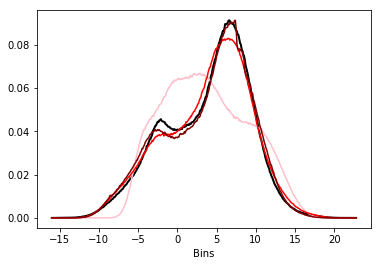

In [79]:
pdfs["truth"].plot(color='k', lw=2)
pdfs['corr_gan_generator_0501_epoch_0001.h5'].plot(color='pink')
pdfs['corr_gan_generator_0501_epoch_0010.h5'].plot(color='red')
pdfs['corr_gan_generator_0501_epoch_0030.h5'].plot(color='maroon')

In [21]:
def plot_gan_pdfs_animated(gan_index, pdf_type="rand"):
    epochs = np.array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 22, 24, 26, 28, 30])
    pdfs = pd.read_csv(join(data_path, f"gan_{gan_index:03d}_offline_pdfs.csv"), index_col="Bins")
    fig, ax = plt.subplots(figsize=(6, 4))
    fig.set_tight_layout(True)
    ax.plot(pdfs.index, pdfs["truth"], color='k', ls='--', lw=3, label="Truth")
    gan_pdf, = ax.plot(pdfs.index, pdfs[f"{pdf_type}_gan_generator_{gan_index:04d}_epoch_{epochs[0]:04d}.h5"], color="red", lw=2)
    ax.set_xlabel("U(X)", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.set_title(f"Lorenz GAN {gan_index_label[gan_index]} Epoch {epochs[0]}", fontsize=14, fontweight="bold")
    ax.set_ylim(0, 0.15)
    def update(i):
        title = f"Lorenz GAN {gan_index_label[gan_index]} Epoch {epochs[i]}"
        print(title)
        ax.set_title(title, fontsize=14, fontweight="bold")
        gan_pdf.set_ydata(pdfs[f"{pdf_type}_gan_generator_{gan_index:04d}_epoch_{epochs[i]:04d}.h5"])
        return gan_pdf, ax
    anim = FuncAnimation(fig, update, frames=np.arange(0, epochs.size), interval=1000)
    anim.save(join("./", f"{pdf_type}_gan_pdf_anim_{gan_index:03d}.gif"), dpi=120, writer="imagemagick")

Lorenz GAN XU-lrg-r Epoch 1
Lorenz GAN XU-lrg-r Epoch 1
Lorenz GAN XU-lrg-r Epoch 2
Lorenz GAN XU-lrg-r Epoch 3
Lorenz GAN XU-lrg-r Epoch 4
Lorenz GAN XU-lrg-r Epoch 5
Lorenz GAN XU-lrg-r Epoch 6
Lorenz GAN XU-lrg-r Epoch 7
Lorenz GAN XU-lrg-r Epoch 8
Lorenz GAN XU-lrg-r Epoch 9
Lorenz GAN XU-lrg-r Epoch 10
Lorenz GAN XU-lrg-r Epoch 11
Lorenz GAN XU-lrg-r Epoch 12
Lorenz GAN XU-lrg-r Epoch 13
Lorenz GAN XU-lrg-r Epoch 14
Lorenz GAN XU-lrg-r Epoch 15
Lorenz GAN XU-lrg-r Epoch 16
Lorenz GAN XU-lrg-r Epoch 17
Lorenz GAN XU-lrg-r Epoch 18
Lorenz GAN XU-lrg-r Epoch 19
Lorenz GAN XU-lrg-r Epoch 20
Lorenz GAN XU-lrg-r Epoch 22
Lorenz GAN XU-lrg-r Epoch 24
Lorenz GAN XU-lrg-r Epoch 26
Lorenz GAN XU-lrg-r Epoch 28
Lorenz GAN XU-lrg-r Epoch 30
Lorenz GAN XU-med-r Epoch 1
Lorenz GAN XU-med-r Epoch 1
Lorenz GAN XU-med-r Epoch 2
Lorenz GAN XU-med-r Epoch 3
Lorenz GAN XU-med-r Epoch 4
Lorenz GAN XU-med-r Epoch 5
Lorenz GAN XU-med-r Epoch 6
Lorenz GAN XU-med-r Epoch 7
Lorenz GAN XU-med-r Epoch 8
Lore

/glade/work/dgagne/ncar_pylib_dl/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


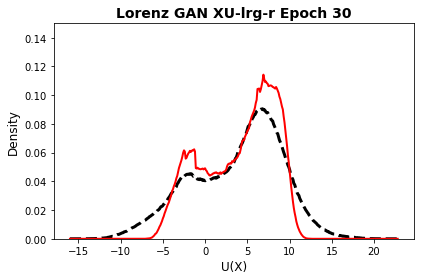

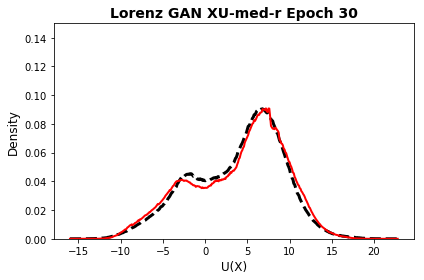

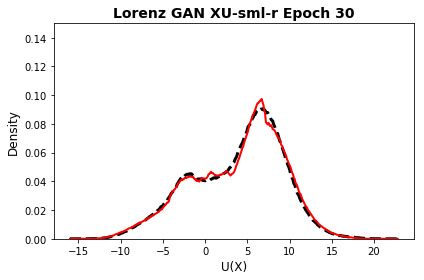

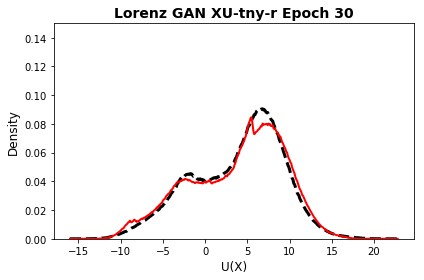

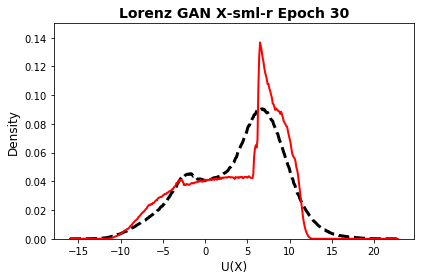

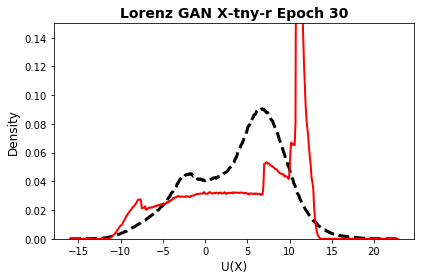

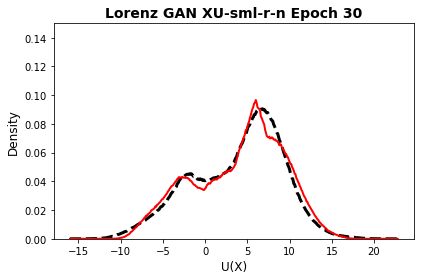

In [23]:
for gan_index in [500, 501, 502, 503, 602, 603, 702]:
    plot_gan_pdfs_animated(gan_index, "det")

In [11]:
time_corr = pd.read_csv(join(data_path, "gan_202_time_correlations.csv"), index_col="Time Lag")


(0, 100)

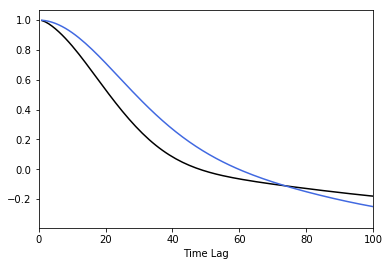

In [13]:
plt.figure(figsize=(6, 4))
time_corr["truth"].plot(color='k')
#time_corr['corr_gan_generator_0502_epoch_0030.h5'].plot(color='red', label="Correlated Random")
time_corr['det_gan_generator_0202_epoch_0030.h5'].plot(color='royalblue', label="Deterministic")
plt.xlim(0, 100)

In [109]:
time_corr

Index(['Time Lag', 'truth', 'det_gan_generator_0202_epoch_0001.h5',
       'det_gan_generator_0202_epoch_0002.h5',
       'det_gan_generator_0202_epoch_0003.h5',
       'det_gan_generator_0202_epoch_0004.h5',
       'det_gan_generator_0202_epoch_0005.h5',
       'det_gan_generator_0202_epoch_0006.h5',
       'det_gan_generator_0202_epoch_0007.h5',
       'det_gan_generator_0202_epoch_0008.h5',
       'det_gan_generator_0202_epoch_0009.h5',
       'det_gan_generator_0202_epoch_0010.h5',
       'det_gan_generator_0202_epoch_0011.h5',
       'det_gan_generator_0202_epoch_0012.h5',
       'det_gan_generator_0202_epoch_0013.h5',
       'det_gan_generator_0202_epoch_0014.h5',
       'det_gan_generator_0202_epoch_0015.h5',
       'det_gan_generator_0202_epoch_0016.h5',
       'det_gan_generator_0202_epoch_0017.h5',
       'det_gan_generator_0202_epoch_0018.h5',
       'det_gan_generator_0202_epoch_0019.h5',
       'det_gan_generator_0202_epoch_0020.h5',
       'det_gan_generator_0202_epoch_00

/glade/work/dgagne/ncar_pylib_dl/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LinearRegression from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [67]:
poly_model

NameError: name 'poly_model' is not defined

array([[1.        , 0.76459934],
       [0.76459934, 1.        ]])

(array([[        nan,         nan,         nan,         nan, 2.00000e+00,
         6.00000e+00, 5.40000e+01, 1.00000e+02, 1.59000e+02, 1.78000e+02,
         1.82000e+02, 1.50000e+02, 9.90000e+01, 6.60000e+01, 3.70000e+01,
         2.10000e+01, 8.00000e+00, 2.00000e+00,         nan,         nan],
        [        nan,         nan,         nan, 5.00000e+00, 6.20000e+01,
         3.26000e+02, 1.13600e+03, 2.47900e+03, 3.30200e+03, 2.98000e+03,
         2.37700e+03, 1.88600e+03, 1.42400e+03, 9.12000e+02, 4.56000e+02,
         1.48000e+02, 4.30000e+01, 1.30000e+01, 1.00000e+00,         nan],
        [        nan,         nan, 1.00000e+00, 1.70000e+01, 1.77000e+02,
         1.09200e+03, 4.68000e+03, 1.12340e+04, 1.46790e+04, 1.09840e+04,
         7.83100e+03, 6.32500e+03, 4.31600e+03, 2.06000e+03, 7.43000e+02,
         1.75000e+02, 2.90000e+01, 3.00000e+00,         nan,         nan],
        [        nan,         nan, 1.00000e+00, 4.00000e+01, 5.28000e+02,
         3.11500e+03, 1.10530e+04, 

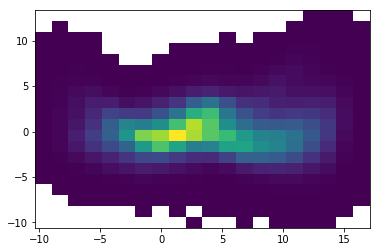

In [139]:
plt.hist2d(test_data["X_t"], poly_res, bins=20, cmin=1, norm=)

In [2]:
exp_path = "/glade/work/dgagne/exp_20_stoch/"

In [4]:
climate = xr.open_dataset(join(exp_path, "lorenz_output.nc"))

In [19]:
(20000000 - 2000) // 5

3999600

In [26]:
def process_lorenz_data(X_out, times, steps, J, F, dt, x_skip, t_skip, u_scale):
    """
    Sample from Lorenz model output and reformat the data into a format more amenable to machine learning.


    Args:
        X_out (ndarray): Lorenz 96 model output
        Y_out (ndarray):
        J (int): number of Y variables per X variable
        x_skip (int): number of X variables to skip when sampling the data
        t_skip (int): number of time steps to skip when sampling the data

    Returns:
        combined_data: pandas DataFrame
    """
    x_series_list = []
    y_series_list = []
    y_prev_list = []
    ux_series_list = []
    ux_prev_series_list = []
    u_series_list = []
    u_prev_series_list = []
    x_s = np.arange(0, X_out.shape[1], x_skip)
    t_s = np.arange(2, X_out.shape[0] - 1, t_skip)
    t_p = t_s - 1
    time_list = []
    step_list = []
    x_list = []
    K = X_out.shape[1]
    for k in x_s:
        x_series_list.append(X_out[t_s, k: k + 1])
        ux_series_list.append((-X_out[t_s, k - 1] * (X_out[t_s, k - 2] - X_out[t_s, (k + 1) % K]) - X_out[t_s, k] + F) -
                              (X_out[t_s + 1, k] - X_out[t_s, k]) / dt)
        ux_prev_series_list.append((-X_out[t_p, k - 1] * (X_out[t_p, k - 2] - X_out[t_p, (k + 1) % K]) - X_out[t_p, k]
                                    + F) - (X_out[t_s, k] - X_out[t_p, k]) / dt)
        #y_series_list.append(Y_out[t_s, k * J: (k + 1) * J])
        #y_prev_list.append(Y_out[t_p, k * J: (k + 1) * J])
        #u_series_list.append(np.expand_dims(u_scale * Y_out[t_s, k * J: (k+1) * J].sum(axis=1), 1))
        #u_prev_series_list.append(np.expand_dims(u_scale * Y_out[t_p, k * J: (k+1) * J].sum(axis=1), 1))
        time_list.append(times[t_s])
        step_list.append(steps[t_s])
        x_list.append(np.ones(time_list[-1].size) * k)
    x_cols = ["X_t"]
    y_cols = ["Y_t+1_{0:d}".format(y) for y in range(J)]
    #y_p_cols = ["Y_t_{0:d}".format(y) for y in range(J)]
    #u_cols = ["Uy_t", "Uy_t+1", "Ux_t", "Ux_t+1"]
    u_cols = ["Ux_t", "Ux_t+1"]
    combined_data = pd.DataFrame(np.vstack(x_series_list), columns=x_cols)
    combined_data.loc[:, "time"] = np.concatenate(time_list)
    combined_data.loc[:, "step"] = np.concatenate(step_list)
    combined_data.loc[:, "x_index"] = np.concatenate(x_list)
    combined_data.loc[:, "u_scale"] = u_scale
    combined_data.loc[:, "Ux_t+1"] = np.concatenate(ux_series_list)
    combined_data.loc[:, "Ux_t"] = np.concatenate(ux_prev_series_list)
    #combined_data.loc[:, "Uy_t+1"] = np.concatenate(u_series_list)
    #combined_data.loc[:, "Uy_t"] = np.concatenate(u_prev_series_list)
    #combined_data = pd.concat([combined_data, pd.DataFrame(np.vstack(y_prev_list), columns=y_p_cols),
    #                           pd.DataFrame(np.vstack(y_series_list), columns=y_cols)], axis=1)
    out_cols = ["x_index", "step", "time", "u_scale"] + x_cols + u_cols
    return combined_data.loc[:, out_cols]

In [20]:
saved_steps = 3999600
split_step = int(0.1 * saved_steps)
print(split_step)

399960


In [60]:
all_test = process_lorenz_data(climate["lorenz_x"][split_step:].values, 
                               climate["time"][split_step:].values, climate["step"][split_step:].values,
                               climate.attrs["J"], climate.attrs["F"], 0.005, 1, 1, 1)

In [91]:
all_test.to_csv("/glade/work/dgagne/exp_20_stoch/lorenz_combined_output_test_all_times.csv", index=False)

In [93]:
all_test.loc[all_test["x_index"] == 0].to_csv("/glade/work/dgagne/exp_20_stoch/lorenz_combined_output_test_x0.csv", index=False)

In [76]:
all_train = process_lorenz_data(climate["lorenz_x"][:split_step].values, 
                               climate["time"][:split_step].values, climate["step"][:split_step].values,
                               climate.attrs["J"], climate.attrs["F"], 0.005, 1, 1, 1)

In [59]:
climate.attrs["time_step"]

0.001

In [82]:
sg = SubModelGAN("/glade/work/dgagne/exp_20_stoch/gan_generator_0102_epoch_0030.h5")

In [85]:
sg_preds = sg.predict_batch(all_test[["X_t", "Ux_t"]], np.zeros((all_test.shape[0], 1)), batch_size=16384, stochastic=0)

Start batches 28797096
End batches 28797096


In [87]:
sg_train_preds = sg.predict_batch(all_train[["X_t", "Ux_t"]], np.zeros((all_train.shape[0], 1)), batch_size=16384, stochastic=0)

Start batches 3199656
End batches 3199656


In [88]:
res = all_test["Ux_t+1"].values - sg_preds
train_res = all_train["Ux_t+1"].values - sg_train_preds

In [89]:
np.corrcoef(res[all_test["x_index"] == 0][1:],res[all_test["x_index"] == 0][:-1])

array([[1.        , 0.97268683],
       [0.97268683, 1.        ]])

In [90]:
np.corrcoef(train_res[1:],train_res[:-1])

array([[1.        , 0.97280637],
       [0.97280637, 1.        ]])

/glade/work/dgagne/ncar_pylib_dl/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


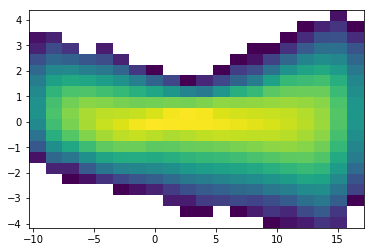

In [75]:
_ = plt.hist2d(all_test["X_t"], res, bins=20, cmin=1, norm=LogNorm())

(array([  20808.,  622398., 4152250., 7952988., 4877745., 5065231.,
        3955507., 1713403.,  418313.,   18453.]),
 array([-14.86809158, -10.74587765,  -6.62366371,  -2.50144978,
          1.62076416,   5.7429781 ,   9.86519203,  13.98740597,
         18.1096199 ,  22.23183384,  26.35404778]),
 <a list of 10 Patch objects>)

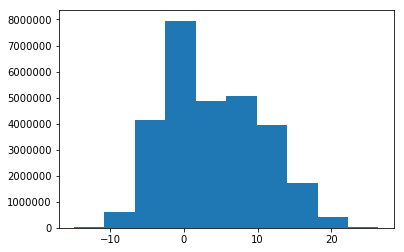

In [57]:
plt.hist(sg_preds)

(array([3.933000e+03, 2.557710e+05, 1.635914e+06, 4.439698e+06,
        5.081097e+06, 8.875414e+06, 7.007852e+06, 1.342184e+06,
        1.510990e+05, 4.134000e+03]),
 array([-17.08813999, -13.0245893 ,  -8.96103862,  -4.89748793,
         -0.83393724,   3.22961345,   7.29316414,  11.35671483,
         15.42026552,  19.48381621,  23.5473669 ]),
 <a list of 10 Patch objects>)

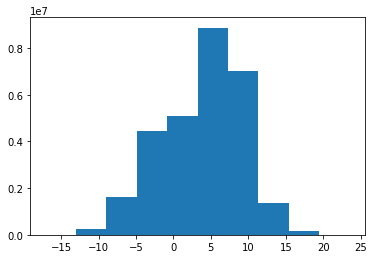

In [65]:
plt.hist(all_test["Ux_t+1"])

In [70]:
poly_preds = poly_model.predict_mean(all_test[["X_t"]].values)

In [71]:
poly_res = all_test["Ux_t+1"].values - poly_preds
np.corrcoef(poly_res[1:], poly_res[:-1])

array([[1.        , 0.98553877],
       [0.98553877, 1.        ]])